# Natural Language Processing - Hotel Reviews Sentiment Prediction

## Libraries and settings

In [1]:
# Libraries
import os
import re
import numpy as np
import pandas as pd
import random
import string

import matplotlib.pyplot as plt
from wordcloud import WordCloud

import nltk

# Import only once
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Set seed
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Current working directory
print('Current working directory:', os.getcwd())

[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/vscode/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/vscode/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/vscode/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Current working directory: /workspaces/data_analytics/Week_11


## Import hotel reviews
- For detailed description of data see: https://www.kaggle.com/datasets/andrewmvd/trip-advisor-hotel-reviews

In [2]:
# Import original data
data_orig = pd.read_csv('tripadvisor_hotel_reviews.csv', sep=",", encoding='utf-8')

# Subset of the data
sub_01 = data_orig.loc[data_orig['Rating'].isin([1])].sample(n=1000, random_state=42)
sub_03 = data_orig.loc[data_orig['Rating'].isin([3])].sample(n=1000, random_state=42)
sub_05 = data_orig.loc[data_orig['Rating'].isin([5])].sample(n=1000, random_state=42)

# Concatenating the subsets to one data frame
data = pd.concat([sub_01, sub_03, sub_05]).reset_index(drop=True)
print('Number of reviews in data: {}'.format(len(data)))

data

Number of reviews in data: 3000


,Review,Rating
0,"old rude blah reason stayed jacuzzi suite, wis...",1
1,"hated, just got punta cana stayed melia caribe...",1
2,absolutely horrible stayed 30th august jolly c...,1
3,"problems way stayed 2 nights, property not bad...",1
4,tourists stay away bad address unless want roc...,1
...,...,...
2995,awesome place stay waterfront wharf hotel quit...,5
2996,cool beans excellent hotel cool location centr...,5
2997,"stay, budget travellers really offer lot price...",5
2998,great place family 5 visited melia caribe dec ...,5


## Check missing values

In [3]:
data.isna().sum()

Review    0
Rating    0
dtype: int64

## Number of hotel reviews per sentiment class in 'data'

In [4]:
df_class = data['Rating'].value_counts()
df_class

Rating
1    1000
3    1000
5    1000
Name: count, dtype: int64

## Wordcloud with most frequently used words

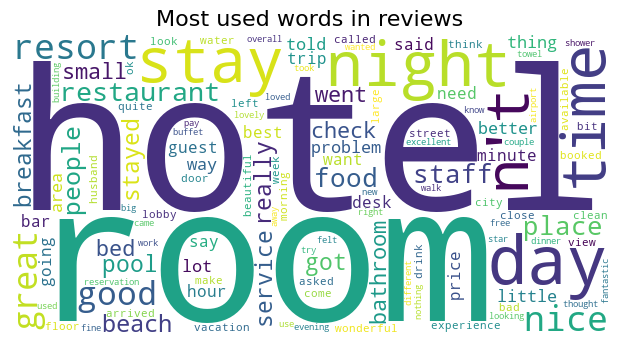

In [5]:
# Wordcloud function
def wordCloud_generator(data, title=None):
    
    wordcloud = WordCloud(height=300,
                          width=600,
                          background_color ='white',
                          min_font_size = 8
                         ).generate(" ".join(data.values))
    
    # Plot the WordCloud image                        
    plt.figure(figsize = (6, 4), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title,fontsize=16)
    plt.show()
    
# Create Wordcloud
wordCloud_generator(data['Review'], title="Most used words in reviews")

## Define X and y data

In [6]:
X = data['Review'].copy()
y = data['Rating'].copy()

print('Hotel Reviews:')
print(X)

print('\nSentiments:')
print(y)

Hotel Reviews:
0       old rude blah reason stayed jacuzzi suite, wis...
1       hated, just got punta cana stayed melia caribe...
2       absolutely horrible stayed 30th august jolly c...
3       problems way stayed 2 nights, property not bad...
4       tourists stay away bad address unless want roc...
                              ...                        
2995    awesome place stay waterfront wharf hotel quit...
2996    cool beans excellent hotel cool location centr...
2997    stay, budget travellers really offer lot price...
2998    great place family 5 visited melia caribe dec ...
2999    phenomenal place, best kept secrets waikiki be...
Name: Review, Length: 3000, dtype: object

Sentiments:
0       1
1       1
2       1
3       1
4       1
       ..
2995    5
2996    5
2997    5
2998    5
2999    5
Name: Rating, Length: 3000, dtype: int64


## Distribution of sentence length

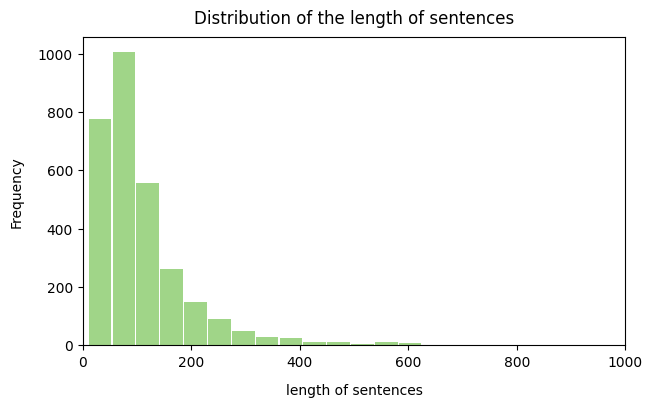

In [7]:
# Calculate length
length_dist = [len(x.split(" ")) for x in X]

# Plot Histogram
fig = plt.figure( figsize=(7,4))
n, bins, patches = plt.hist(x=length_dist, 
                            bins=30, 
                            color='#42AD12',
                            alpha=0.5, 
                            rwidth=0.95
                   )
plt.ticklabel_format(style='plain')

# Set x limits
plt.xlim(0, 1000)

# Set labels
plt.xlabel('length of sentences', fontsize=10, labelpad=10)
plt.ylabel('Frequency', fontsize=10, labelpad=10)
plt.title('Distribution of the length of sentences', fontsize=12, pad=10)

plt.show()

## Text preprocessing
### Steps:
- Removing punctuations
- Text to lowercase
- Tokenization
- Removing stopwords
- Stemming/Lemmatization

### Removing punctuations

In [8]:
# Defining the function to remove punctuations
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree

# Storing the puntuation free text
X_cleaned_01 = X.apply(lambda x:remove_punctuation(x))
X_cleaned_01

0       old rude blah reason stayed jacuzzi suite wish...
1       hated just got punta cana stayed melia caribe ...
2       absolutely horrible stayed 30th august jolly c...
3       problems way stayed 2 nights property not bad ...
4       tourists stay away bad address unless want roc...
                              ...                        
2995    awesome place stay waterfront wharf hotel quit...
2996    cool beans excellent hotel cool location centr...
2997    stay budget travellers really offer lot price ...
2998    great place family 5 visited melia caribe dec ...
2999    phenomenal place best kept secrets waikiki bea...
Name: Review, Length: 3000, dtype: object

### Text to lowercase

In [9]:
X_cleaned_02 = X_cleaned_01.apply(lambda x: x.lower())
X_cleaned_02

0       old rude blah reason stayed jacuzzi suite wish...
1       hated just got punta cana stayed melia caribe ...
2       absolutely horrible stayed 30th august jolly c...
3       problems way stayed 2 nights property not bad ...
4       tourists stay away bad address unless want roc...
                              ...                        
2995    awesome place stay waterfront wharf hotel quit...
2996    cool beans excellent hotel cool location centr...
2997    stay budget travellers really offer lot price ...
2998    great place family 5 visited melia caribe dec ...
2999    phenomenal place best kept secrets waikiki bea...
Name: Review, Length: 3000, dtype: object

### Tokenization

In [10]:
# Function for tokenization
def tokenization(text):
    tokens = word_tokenize(text)
    return tokens

# Applying function
X_cleaned_03 = X_cleaned_02.apply(lambda x: tokenization(x))
X_cleaned_03

0       [old, rude, blah, reason, stayed, jacuzzi, sui...
1       [hated, just, got, punta, cana, stayed, melia,...
2       [absolutely, horrible, stayed, 30th, august, j...
3       [problems, way, stayed, 2, nights, property, n...
4       [tourists, stay, away, bad, address, unless, w...
                              ...                        
2995    [awesome, place, stay, waterfront, wharf, hote...
2996    [cool, beans, excellent, hotel, cool, location...
2997    [stay, budget, travellers, really, offer, lot,...
2998    [great, place, family, 5, visited, melia, cari...
2999    [phenomenal, place, best, kept, secrets, waiki...
Name: Review, Length: 3000, dtype: object

### Removing stopwords

In [11]:
# Stop words present in the library
stopwords = nltk.corpus.stopwords.words('english')

# Print stopwords
print('English stopwords:')
print(stopwords)

# Defining the function to remove stopwords from tokenized text
def remove_stopwords(text):
    output = [i for i in text if i not in stopwords]
    return output

# Applying the function
X_cleaned_04 = X_cleaned_03.apply(lambda x:remove_stopwords(x))
X_cleaned_04

English stopwords:
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'sam

0       [old, rude, blah, reason, stayed, jacuzzi, sui...
1       [hated, got, punta, cana, stayed, melia, carib...
2       [absolutely, horrible, stayed, 30th, august, j...
3       [problems, way, stayed, 2, nights, property, b...
4       [tourists, stay, away, bad, address, unless, w...
                              ...                        
2995    [awesome, place, stay, waterfront, wharf, hote...
2996    [cool, beans, excellent, hotel, cool, location...
2997    [stay, budget, travellers, really, offer, lot,...
2998    [great, place, family, 5, visited, melia, cari...
2999    [phenomenal, place, best, kept, secrets, waiki...
Name: Review, Length: 3000, dtype: object

### Stemming

In [12]:
# Defining the object for stemming
porter_stemmer = PorterStemmer()

# Defining a function for stemming
def stemming(text):
    stem_text = [porter_stemmer.stem(word) for word in text]
    return stem_text

# Applying the function (we use X_cleaned_04 here)
X_cleaned_05 = X_cleaned_04.apply(lambda x: stemming(x))
X_cleaned_05

0       [old, rude, blah, reason, stay, jacuzzi, suit,...
1       [hate, got, punta, cana, stay, melia, carib, t...
2       [absolut, horribl, stay, 30th, august, jolli, ...
3       [problem, way, stay, 2, night, properti, bad, ...
4       [tourist, stay, away, bad, address, unless, wa...
                              ...                        
2995    [awesom, place, stay, waterfront, wharf, hotel...
2996    [cool, bean, excel, hotel, cool, locat, centra...
2997    [stay, budget, travel, realli, offer, lot, pri...
2998    [great, place, famili, 5, visit, melia, carib,...
2999    [phenomen, place, best, kept, secret, waikiki,...
Name: Review, Length: 3000, dtype: object

### Lemmatization

In [13]:
# Defining the object for lemmatization
lemmatizer = WordNetLemmatizer()

# Defining a function for lemmatization
def lemm(text):
    lemm_text = [lemmatizer.lemmatize(word, pos='v') for word in text]
    return lemm_text

# Applying the function (we use X_cleaned_04 here)
X_cleaned_06 = X_cleaned_04.apply(lambda x: lemm(x))
X_cleaned_06

0       [old, rude, blah, reason, stay, jacuzzi, suite...
1       [hat, get, punta, cana, stay, melia, caribe, t...
2       [absolutely, horrible, stay, 30th, august, jol...
3       [problems, way, stay, 2, nights, property, bad...
4       [tourists, stay, away, bad, address, unless, w...
                              ...                        
2995    [awesome, place, stay, waterfront, wharf, hote...
2996    [cool, bean, excellent, hotel, cool, location,...
2997    [stay, budget, travellers, really, offer, lot,...
2998    [great, place, family, 5, visit, melia, caribe...
2999    [phenomenal, place, best, keep, secrets, waiki...
Name: Review, Length: 3000, dtype: object

## Document-Term Matrix

In [14]:
# Define dummy variable
def dummy_fun(doc):
    return doc

count = CountVectorizer(
    analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None)

# Document-Term Matrix (we use 'X_cleaned_06' as the input)
X_cleaned_07 = count.fit_transform(X_cleaned_06).toarray()
print('Document-Term Matrix:')
print(X_cleaned_07)

# Shape
print('\nShape of the Document-Term Matrix')
print(X_cleaned_07.shape)

# Summary statistics
print('\nSummary statistics')
print(f'min: {np.min(X_cleaned_07):.4f}')
print(f'max: {np.max(X_cleaned_07):.4f}')

Document-Term Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

Shape of the Document-Term Matrix
(3000, 22595)

Summary statistics
min: 0.0000
max: 33.0000


## Term Frequency - Inverse Document Frequency (TF-IDF) Matrix

In [15]:
# Define dummy variable
def dummy_fun(doc):
    return doc

tfidf = TfidfVectorizer(
    analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None)

# TF-IDF Matrix (we use 'X_cleaned_06' as the input)
X_cleaned_08 = tfidf.fit_transform(X_cleaned_06).toarray()
print('TF-IDF Matrix:')
print(X_cleaned_08)

# Shape
print('\nShape of the TF-IDF Matrix')
print(X_cleaned_08.shape)

# Summary statistics
print('\nSummary statistics')
print(f'min: {np.min(X_cleaned_08):.4f}')
print(f'max: {np.max(X_cleaned_08):.4f}')

TF-IDF Matrix:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

Shape of the TF-IDF Matrix
(3000, 22595)

Summary statistics
min: 0.0000
max: 0.8173


## Split data into train/test

In [16]:
# Train/test samples
X_train, X_test, y_train, y_test = train_test_split(X_cleaned_08, 
                                                    y, 
                                                    test_size=0.20, 
                                                    random_state=67)

# Print X_train
print('X_train:')
print(X_train)

# Print y_train
print('\ny_train:')
print(y_train)

X_train:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

y_train:
563     1
2189    5
2379    5
2973    5
1465    3
       ..
905     1
2055    5
1738    3
821     1
2883    5
Name: Rating, Length: 2400, dtype: int64


## Model Training

In [17]:
# Initialize the random forest model 
rfc = RandomForestClassifier(max_depth=20,
                             n_estimators=200,
                             min_samples_leaf=15,
                             random_state=42)

# Train the random forest model
rfc = rfc.fit(X_train, y_train)

##  Model Evaluation

### Create model predictions

In [18]:
# Predict the target variable
y_pred = rfc.predict(X_test)
y_pred

array([3, 5, 5, 5, 5, 5, 3, 3, 1, 5, 3, 5, 5, 1, 1, 5, 5, 1, 1, 3, 5, 3,
       5, 1, 1, 3, 5, 1, 5, 1, 5, 3, 5, 5, 1, 5, 1, 1, 1, 5, 5, 3, 5, 3,
       5, 5, 3, 1, 5, 3, 1, 1, 1, 1, 3, 3, 5, 1, 3, 3, 3, 3, 5, 1, 3, 5,
       1, 5, 1, 1, 1, 1, 5, 1, 5, 3, 1, 5, 1, 1, 5, 5, 3, 1, 1, 3, 1, 1,
       3, 3, 1, 3, 1, 1, 5, 3, 1, 5, 1, 3, 3, 1, 1, 1, 5, 3, 3, 5, 1, 3,
       3, 5, 3, 5, 5, 1, 5, 1, 1, 3, 5, 1, 1, 1, 5, 5, 1, 5, 1, 1, 3, 5,
       1, 1, 5, 3, 1, 3, 1, 5, 5, 3, 1, 1, 1, 5, 5, 5, 5, 1, 5, 1, 3, 1,
       3, 5, 5, 5, 1, 3, 1, 1, 1, 3, 3, 5, 1, 1, 1, 1, 3, 5, 1, 1, 5, 3,
       3, 3, 5, 1, 3, 3, 3, 3, 5, 5, 1, 1, 5, 1, 3, 1, 5, 5, 5, 5, 1, 1,
       1, 3, 5, 5, 5, 1, 5, 3, 1, 1, 3, 1, 5, 5, 1, 1, 1, 1, 3, 1, 3, 5,
       1, 3, 3, 1, 1, 3, 3, 1, 5, 5, 5, 1, 1, 3, 1, 1, 3, 5, 1, 3, 5, 5,
       3, 5, 1, 1, 3, 1, 5, 1, 1, 5, 3, 1, 5, 5, 5, 5, 5, 5, 3, 3, 3, 5,
       3, 5, 3, 5, 5, 3, 1, 3, 3, 5, 1, 5, 1, 5, 5, 5, 1, 5, 1, 3, 3, 1,
       1, 5, 3, 1, 5, 1, 1, 3, 5, 1, 1, 1, 1, 3, 1,

### Measuring the Accuracy

In [19]:
# Accuracy
print(f'Accuracy: {accuracy_score(y_pred, y_test):.4f}')

Accuracy: 0.7817


### Confusion matrix

In [20]:
# Confusion matrix
print(confusion_matrix(y_test, y_pred))

[[175  13   4]
 [ 42 118  34]
 [  8  30 176]]


### Classification Report

In [21]:
# Classification Report
print(classification_report(y_test, 
                            y_pred))

              precision    recall  f1-score   support

           1       0.78      0.91      0.84       192
           3       0.73      0.61      0.66       194
           5       0.82      0.82      0.82       214

    accuracy                           0.78       600
   macro avg       0.78      0.78      0.78       600
weighted avg       0.78      0.78      0.78       600



### Jupyter notebook --footer info-- (please always provide this at the end of each submitted notebook)

In [22]:
import os
import platform
import socket
from platform import python_version
from datetime import datetime

print('-----------------------------------')
print(os.name.upper())
print(platform.system(), '|', platform.release())
print('Datetime:', datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print('Python Version:', python_version())
print('-----------------------------------')

-----------------------------------
POSIX
Linux | 6.2.0-1016-azure
Datetime: 2023-12-12 14:56:53
Python Version: 3.10.13
-----------------------------------
